In [1]:
import gym
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics
import pandas as pd

In [2]:
def beers_law(solution, path_length, coeffs, min_wavelength, max_wavelength):
    """
    Applys Beers-Lampert Law to get the total absorbtion
    of a solution.
    Inputs:
    solution: Dictionary of the form Name->Concentration
    path_length: float
    coeffs: pd dataframe with column 'Wavelength' and coefficients in other column.
    Each other column corresponds to the coffiecient at that wavelength for the 
    title of the column which should be the same as the solution
    
    'Wavelength', 'Dye1', 'Dye2'
    600, .1, 0
    601, .2, .1

    Returns the overall absorbtion as a float
    """
    wavelengths = []
    spectra = []
    absorbtion = 0
    coeffs_with_index = coeffs.set_index('Wavelength')
    coeffs_with_index.sort_index(inplace=True)
    coeffs_with_index.dropna(inplace=True)
    
    for index, row in coeffs_with_index.iterrows():
        if index >= min_wavelength and index <= max_wavelength:
            for key in solution:
                absorbtion += solution[key] * coeffs_with_index.loc[index, key]
            wavelengths.append(index)
            spectra.append(absorbtion)
            absorbtion = 0
        
    
    return wavelengths, spectra*path_length


def random_solution(coeffs, complexity):
    """
    """
    cont = True
    while cont:
        opt = coeffs.columns[1:]
        solution = {}
        rand = np.random.rand(len(opt))
        for i, name in enumerate(opt):
            if rand[i] > complexity:
                solution[name] = np.random.random() + .01
                
        if len(solution) is not 0:
            cont = False
    
    return solution

def random_spectra(path_length, coeffs, min_wavelength, max_wavelength, complexity):
    """
    """
    
    solution = random_solution(coeffs, complexity)
    return beers_law(solution, path_length, coeffs, min_wavelength, max_wavelength)

<>:49: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:49: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-2-45729f7a6178>:49: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if len(solution) is not 0:


In [3]:
class CustomEnv(gym.Env):
  """Custom Environment that follows gym interface"""
  metadata = {'render.modes': ['human']}

  def __init__(self, goal, coeffs, dye_c):
    super(CustomEnv, self).__init__()
    # Define action and observation space
    # They must be gym.spaces objects
    # Example when using discrete actions:
    self.action_space = gym.spaces.Box(low=-5, high=5, shape=(3,1), dtype=np.float32)
    # Example for using image as input:
    self.observation_space = gym.spaces.Box(low=0, high=5,
                                       shape=(1,len(coeffs)), dtype=np.float32)
    
    
    
    self.sol = {'red': 0, 'green': 0, 'blue': 0}
    self.goal = goal
    self.coeffs = coeffs
    self.total = 0
    self.dye_c = dye_c
    self.iter = 0

  def step(self, action):
    #print(action)
    new_total = self.total + action[0] + action[1] + action[2] + 15

    
    self.sol['red'] = (action[0]+5) * dye_c['red'] / new_total
    self.sol['green'] = (action[1]+5) * dye_c['green'] / new_total
    self.sol['blue'] = (action[2]+5)* dye_c['blue'] / new_total
    
    #print(self.sol)
    self.total = new_total
    
    
    curr = beers_law(self.sol, 1, self.coeffs, 300, 700)[1]
    if self.iter % 50 == 0: 
        plt.figure()
        plt.plot(curr, label='curr')
        plt.plot(self.goal, label='goal')
        plt.legend()
        if(self.iter == 10):
            print('new ep')
            
    reward = -sklearn.metrics.mean_squared_error(curr, self.goal) * 10
    #print(reward)
    self.iter +=1
    done = True

    
    #print('reward is '+ str(reward))
    info = {}
    return curr, reward, done, info


  def reset(self):
    self.sol = {'red':0, 'green':0, 'blue':0}
    #self.goal = random_spectra(1, self.coeffs, 300, 700, .3)[1]
    #self.iter = 0
    
    return self.goal  # reward, done, info can't be included
  def render(self, mode='human'):
    pass
  def close (self):
    pass

  def get_color(self, i):
    i = np.rint(i)
    if i == -1:
        return 'red'
    elif i == 0:
        return 'green'
    elif i == 1:
        return 'blue'

In [4]:
coeff = pd.read_csv('beers_law/rgb_coeff')
coeff.drop(labels='Unnamed: 0', axis=1, inplace=True)
spectra = random_spectra(1, coeff, 300, 700, .3)
dye_c = {'red': 1, 'blue': 1, 'green': 1}
env = CustomEnv(spectra[1], coeff, dye_c)

In [5]:
print(env.observation_space.sample())
print(env.action_space.sample())

[[3.9305742  4.4130344  2.9029603  2.2030246  0.7432402  2.3277836
  3.1772618  3.6791615  2.4378347  4.5340376  3.5388246  3.7843373
  4.3556166  4.925313   4.278188   3.1163583  0.03904796 4.5403147
  2.9780223  0.43511066 1.3658987  1.4462163  3.499473   2.7640848
  4.9833927  1.9115477  0.1604336  0.58070177 1.3607411  3.5171869
  4.4881177  0.24949044 3.120195   2.960697   2.0145855  4.0340023
  1.9946296  4.6548386  2.9013214  1.620979   4.588024   4.157333
  1.7396613  2.3942618  0.6200574 ]]
[[-0.13629533]
 [-1.8334587 ]
 [ 0.7502413 ]]


In [6]:
num_states = 41
num_actions = 3

upper_bound_amount = 5
lower_bound_amount = -5

In [7]:
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process.
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        # Store x into x_prev
        # Makes next noise dependent on current one
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)

In [8]:
class Buffer:
    def __init__(self, batch_size=8):
        self.buffer = pd.DataFrame(columns = ['state', 'action', 'reward', 'next_state'])
        self.batch_size = batch_size

    # Takes (s,a,r,s') obervation tuple as input
    def record(self, obs_tuple):
        #print(obs_tuple)
        self.buffer = self.buffer.append({
            'state': obs_tuple[0],
            'action': obs_tuple[1],
            'reward': obs_tuple[2],
            'next_state': obs_tuple[3]
            
        }, ignore_index=True)
        if len(self.buffer) > self.batch_size:
            self.buffer.drop(index=0, inplace=True)
            self.buffer.reset_index(drop=True, inplace=True)


    # Eager execution is turned on by default in TensorFlow 2. Decorating with tf.function allows
    # TensorFlow to build a static graph out of the logic and computations in our function.
    # This provides a large speed up for blocks of code that contain many small TensorFlow operations such as this one.
    @tf.function
    def update(self, state_batch, action_batch, reward_batch, next_state_batch): 
        # Training and updating Actor & Critic networks.
        # See Pseudo Code.
        with tf.GradientTape() as tape:
            target_actions = target_actor(next_state_batch, training=True)
            tc = target_critic(
                [next_state_batch, target_actions], training=True
            )
            #print('tc')
            #tf.print(tc)
            
            y = reward_batch
            critic_value = critic_model([state_batch, action_batch], training=True)
            #tf.print(critic_value)
            #tf.print(reward_batch)
            #tf.print(y-critic_value)
            #tf.print(tf.math.square(y - critic_value))

            #print(tf.math.reduce_mean(tf.math.square(y - critic_value)))
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value)) * 10
            #tf.print(critic_loss)
            #tf.print(critic_loss)
            #print('---------------')

        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )
        
        with tf.GradientTape() as tape:
            actions = actor_model(state_batch, training=True)
            tf.print(actions)
            critic_value = critic_model([state_batch, actions], training=True)
            # Used `-value` as we want to maximize the value given
            # by the critic for our actions
            actor_loss = -tf.math.reduce_mean(critic_value) * 10
            #tf.print(actor_loss)

        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )
        return actor_loss, critic_loss

    # We compute the loss and update parameters
    def learn(self):
        # Convert to tensors
        state_batch = self.buffer['state']
        action_batch = self.buffer['action']
        reward_batch = self.buffer['reward']
        next_state_batch = self.buffer['next_state']
        
        #print(state_batch)
        #print(state_batch[0])
        #print(state_batch.tolist())
        
        
        state_batch = tf.convert_to_tensor(self.buffer['state'].tolist())
        action_batch = tf.convert_to_tensor(self.buffer['action'].tolist())
        reward_batch = tf.convert_to_tensor(self.buffer['reward'].tolist())
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.buffer['next_state'].tolist())
        #print(reward_batch)

        return self.update(state_batch, action_batch, reward_batch, next_state_batch)


# This update target parameters slowly
# Based on rate `tau`, which is much less than one.
@tf.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))

In [9]:
def get_actor():
    # Initialize weights between -3e-3 and 3-e3
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)

    inputs = layers.Input(shape=(num_states))
    out = layers.Dense(32, activation="relu")(inputs)
    out = layers.Dense(16, activation="relu")(out)
    outputs = layers.Dense(3, activation="sigmoid", kernel_initializer=last_init)(out)

    # Our upper bound is 2.0 for Pendulum.
    #outputs = outputs * upper_bound_amount
    model = tf.keras.Model(inputs, outputs)
    return model


def get_critic():
    # State as input
    state_input = layers.Input(shape=(num_states))
    state_out = layers.Dense(32, activation="relu")(state_input)
    state_out = layers.Dense(16, activation="relu")(state_out)

    # Action as input
    action_input = layers.Input(shape=(num_actions))
    action_out = layers.Dense(16, activation="relu")(action_input)

    # Both are passed through seperate layer before concatenating
    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(64, activation="relu")(concat)
    out = layers.Dense(16, activation="relu")(out)
    outputs = layers.Dense(1)(out)

    # Outputs single value for give state-action
    model = tf.keras.Model([state_input, action_input], outputs)

    return model

In [10]:
def policy(state, noise_object):
    #print(state)
    sampled_actions = tf.squeeze(actor_model(state))
    noise = noise_object()
    # Adding noise to action
    sampled_actions = sampled_actions.numpy() + noise

    # We make sure action is within bounds
    amount_red = np.clip(sampled_actions[0], lower_bound_amount, upper_bound_amount)
    amount_green = np.clip(sampled_actions[1], lower_bound_amount, upper_bound_amount)
    amount_blue = np.clip(sampled_actions[2], lower_bound_amount, upper_bound_amount)
    #print(sampled_actions)

    return [amount_red, amount_green, amount_blue]

In [11]:
std_dev = .05
ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))

actor_model = get_actor()
critic_model = get_critic()

target_actor = get_actor()
target_critic = get_critic()

# Making the weights equal initially
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

# Learning rate for actor-critic models
critic_lr = 0.001
actor_lr = 0.001

critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

total_episodes = 1000
# Discount factor for future rewards
gamma = 0.99
# Used to update target networks
tau = 0.005

buffer = Buffer(8)


[[0.499838352 0.500764549 0.500818372]]
[[0.49772194 0.498930186 0.502721846]
 [0.49772194 0.498930186 0.502721846]]
[[0.495556474 0.496990085 0.503823817]
 [0.495556474 0.496990085 0.503823817]
 [0.495556474 0.496990085 0.503823817]]
[[0.493208349 0.49485141 0.503346622]
 [0.493208349 0.49485141 0.503346622]
 [0.493208349 0.49485141 0.503346622]
 [0.493208349 0.49485141 0.503346622]]
[[0.490628272 0.492477477 0.502401412]
 [0.490628272 0.492477477 0.502401412]
 [0.490628272 0.492477477 0.502401412]
 [0.490628272 0.492477477 0.502401412]
 [0.490628272 0.492477477 0.502401412]]
[[0.487790167 0.489843726 0.500973046]
 [0.487790167 0.489843726 0.500973046]
 [0.487790167 0.489843726 0.500973046]
 [0.487790167 0.489843726 0.500973046]
 [0.487790167 0.489843726 0.500973046]
 [0.487790167 0.489843726 0.500973046]]
[[0.484674871 0.486934751 0.49915418]
 [0.484674871 0.486934751 0.49915418]
 [0.484674871 0.486934751 0.49915418]
 ...
 [0.484674871 0.486934751 0.49915418]
 [0.484674871 0.48693475

[[0.333700716 0.339389443 0.374112874]
 [0.333700716 0.339389443 0.374112874]
 [0.333700716 0.339389443 0.374112874]
 ...
 [0.333700716 0.339389443 0.374112874]
 [0.333700716 0.339389443 0.374112904]
 [0.333700716 0.339389443 0.374112904]]
[[0.320598543 0.326364458 0.361810595]
 [0.320598543 0.326364458 0.361810595]
 [0.320598543 0.326364458 0.361810595]
 ...
 [0.320598543 0.326364458 0.361810595]
 [0.320598543 0.326364458 0.361810595]
 [0.320598543 0.326364458 0.361810595]]
[[0.307014197 0.312836 0.348915517]
 [0.307014197 0.312836 0.348915517]
 [0.307014197 0.312836 0.348915517]
 ...
 [0.307014197 0.312836 0.348915517]
 [0.307014167 0.312836 0.348915517]
 [0.307014167 0.312836 0.348915517]]
[[0.292962641 0.298816055 0.335411489]
 [0.292962641 0.298816055 0.335411489]
 [0.292962641 0.298816055 0.335411489]
 ...
 [0.292962641 0.298816055 0.335411489]
 [0.292962611 0.298816055 0.335411489]
 [0.292962611 0.298816055 0.335411489]]
[[0.278475612 0.284339964 0.321294755]
 [0.278475612 0.284

[[0.00988870859 0.0105063021 0.0134434104]
 [0.00988870859 0.0105063021 0.0134434104]
 [0.00988870859 0.0105063021 0.0134434104]
 ...
 [0.00988870859 0.0105063021 0.0134434104]
 [0.00988870859 0.0105063021 0.0134434104]
 [0.00988870859 0.0105063021 0.0134434104]]
[[0.00881120563 0.00933516 0.0119608343]
 [0.00881120563 0.00933516 0.0119608343]
 [0.00881120563 0.00933516 0.0119608343]
 ...
 [0.00881120563 0.00933516 0.0119608343]
 [0.00881120563 0.00933516 0.0119608343]
 [0.00881120563 0.00933516 0.0119608343]]
[[0.00787982345 0.00831586123 0.0106716454]
 [0.00787982345 0.00831586123 0.0106716454]
 [0.00787982345 0.00831586123 0.0106716454]
 ...
 [0.00787982345 0.00831586123 0.0106716454]
 [0.00787982345 0.00831592083 0.0106716454]
 [0.00787982345 0.00831592083 0.0106716454]]
[[0.00707355142 0.00742900372 0.00955036283]
 [0.00707355142 0.00742900372 0.00955036283]
 [0.00707355142 0.00742900372 0.00955036283]
 ...
 [0.00707355142 0.00742900372 0.00955036283]
 [0.00707355142 0.00742894411

[[0.00135919452 0.00122967362 0.00165718794]
 [0.00135919452 0.00122967362 0.00165718794]
 [0.00135919452 0.00122967362 0.00165718794]
 ...
 [0.00135919452 0.00122967362 0.00165718794]
 [0.00135919452 0.00122970343 0.00165724754]
 [0.00135919452 0.00122970343 0.00165724754]]
[[0.00132423639 0.0011959374 0.00161281228]
 [0.00132423639 0.0011959374 0.00161281228]
 [0.00132423639 0.0011959374 0.00161281228]
 ...
 [0.00132423639 0.0011959374 0.00161281228]
 [0.00132423639 0.0011959374 0.00161281228]
 [0.00132423639 0.0011959374 0.00161281228]]
[[0.00129160285 0.00116458535 0.00157150626]
 [0.00129160285 0.00116458535 0.00157150626]
 [0.00129160285 0.00116458535 0.00157150626]
 ...
 [0.00129160285 0.00116458535 0.00157150626]
 [0.00129160285 0.00116458535 0.00157150626]
 [0.00129160285 0.00116458535 0.00157150626]]
[[0.00126111507 0.00113537908 0.00153321028]
 [0.00126111507 0.00113537908 0.00153321028]
 [0.00126111507 0.00113537908 0.00153321028]
 ...
 [0.00126111507 0.00113537908 0.001533

[[0.000818014145 0.000727504492 0.000988692]
 [0.000818014145 0.000727504492 0.000988692]
 [0.000818014145 0.000727504492 0.000988692]
 ...
 [0.000818014145 0.000727504492 0.000988692]
 [0.000818014145 0.000727504492 0.000988692]
 [0.000818014145 0.000727504492 0.000988692]]
[[0.000808119774 0.000718802214 0.000976860523]
 [0.000808119774 0.000718802214 0.000976860523]
 [0.000808119774 0.000718802214 0.000976860523]
 ...
 [0.000808119774 0.000718802214 0.000976860523]
 [0.000808119774 0.000718802214 0.000976860523]
 [0.000808119774 0.000718802214 0.000976860523]]
[[0.000798493624 0.000710219145 0.000965148211]
 [0.000798493624 0.000710219145 0.000965148211]
 [0.000798493624 0.000710219145 0.000965148211]
 ...
 [0.000798493624 0.000710219145 0.000965148211]
 [0.000798493624 0.000710219145 0.000965148211]
 [0.000798493624 0.000710219145 0.000965148211]]
[[0.000789016485 0.000701934099 0.000953793526]
 [0.000789016485 0.000701934099 0.000953793526]
 [0.000789016485 0.000701934099 0.000953

[[0.000597506762 0.000533908606 0.000723451376]
 [0.000597506762 0.000533908606 0.000723451376]
 [0.000597506762 0.000533908606 0.000723451376]
 ...
 [0.000597506762 0.000533908606 0.000723451376]
 [0.000597536564 0.000533908606 0.000723391771]
 [0.000597536564 0.000533908606 0.000723391771]]
[[0.000591695309 0.000528842211 0.000716358423]
 [0.000591695309 0.000528842211 0.000716358423]
 [0.000591695309 0.000528842211 0.000716358423]
 ...
 [0.000591695309 0.000528842211 0.000716358423]
 [0.000591695309 0.000528842211 0.000716418]
 [0.000591695309 0.000528842211 0.000716418]]
[[0.000585973263 0.000523805618 0.000709474087]
 [0.000585973263 0.000523805618 0.000709474087]
 [0.000585973263 0.000523805618 0.000709474087]
 ...
 [0.000585973263 0.000523805618 0.000709474087]
 [0.000585913658 0.000523835421 0.000709474087]
 [0.000585913658 0.000523835421 0.000709474087]]
[[0.000580310822 0.000518858433 0.000702619553]
 [0.000580310822 0.000518858433 0.000702619553]
 [0.000580310822 0.000518858

[[0.000458031893 0.000411391258 0.000555425882]
 [0.000458031893 0.000411391258 0.000555425882]
 [0.000458031893 0.000411391258 0.000555425882]
 ...
 [0.000458031893 0.000411391258 0.000555425882]
 [0.000458031893 0.000411391258 0.000555425882]
 [0.000458031893 0.000411391258 0.000555425882]]
[[0.000454127789 0.000407993793 0.000550746918]
 [0.000454127789 0.000407993793 0.000550746918]
 [0.000454127789 0.000407993793 0.000550746918]
 ...
 [0.000454127789 0.000407993793 0.000550746918]
 [0.000454127789 0.000407993793 0.000550746918]
 [0.000454127789 0.000407993793 0.000550746918]]
[[0.000450313091 0.000404536724 0.000546097755]
 [0.000450313091 0.000404536724 0.000546097755]
 [0.000450313091 0.000404536724 0.000546097755]
 ...
 [0.000450313091 0.000404536724 0.000546097755]
 [0.000450253487 0.000404626131 0.000546187162]
 [0.000450253487 0.000404626131 0.000546187162]]
[[0.000446438789 0.000401288271 0.000541508198]
 [0.000446438789 0.000401288271 0.000541508198]
 [0.000446438789 0.000

[[0.00036239624 0.000326871872 0.000439971685]
 [0.00036239624 0.000326871872 0.000439971685]
 [0.00036239624 0.000326871872 0.000439971685]
 ...
 [0.00036239624 0.000326871872 0.000439971685]
 [0.00036239624 0.000326871872 0.000439971685]
 [0.00036239624 0.000326871872 0.000439971685]]
[[0.000359594822 0.000324428082 0.000436663628]
 [0.000359594822 0.000324428082 0.000436663628]
 [0.000359594822 0.000324428082 0.000436663628]
 ...
 [0.000359594822 0.000324428082 0.000436663628]
 [0.000359594822 0.000324428082 0.00043669343]
 [0.000359594822 0.000324428082 0.00043669343]]
[[0.000356882811 0.000322014093 0.00043335557]
 [0.000356882811 0.000322014093 0.00043335557]
 [0.000356882811 0.000322014093 0.00043335557]
 ...
 [0.000356882811 0.000322014093 0.00043335557]
 [0.000356882811 0.000322014093 0.000433385372]
 [0.000356882811 0.000322014093 0.000433385372]]
[[0.000354141 0.000319629908 0.000430136919]
 [0.000354141 0.000319629908 0.000430136919]
 [0.000354141 0.000319629908 0.000430136

[[0.000293791294 0.00026601553 0.000357121229]
 [0.000293791294 0.00026601553 0.000357121229]
 [0.000293791294 0.00026601553 0.000357121229]
 ...
 [0.000293791294 0.00026601553 0.000357121229]
 [0.000293791294 0.00026601553 0.000357121229]
 [0.000293791294 0.00026601553 0.000357121229]]
[[0.000291883945 0.000264167786 0.000354707241]
 [0.000291883945 0.000264167786 0.000354707241]
 [0.000291883945 0.000264167786 0.000354707241]
 ...
 [0.000291883945 0.000264167786 0.000354707241]
 [0.000291883945 0.000264257193 0.000354707241]
 [0.000291883945 0.000264257193 0.000354707241]]
[[0.000289797783 0.000262469053 0.000352412462]
 [0.000289797783 0.000262469053 0.000352412462]
 [0.000289797783 0.000262469053 0.000352412462]
 ...
 [0.000289797783 0.000262469053 0.000352412462]
 [0.000289797783 0.000262528658 0.000352352858]
 [0.000289797783 0.000262528658 0.000352352858]]
[[0.000287920237 0.000260740519 0.000349938869]
 [0.000287920237 0.000260740519 0.000349938869]
 [0.000287920237 0.000260740

[[0.000243127346 0.000220865011 0.000295698643]
 [0.000243127346 0.000220865011 0.000295698643]
 [0.000243127346 0.000220865011 0.000295698643]
 ...
 [0.000243127346 0.000220865011 0.000295698643]
 [0.000243157148 0.000220865011 0.000295698643]
 [0.000243157148 0.000220865011 0.000295698643]]
[[0.000241607428 0.000219404697 0.000293940306]
 [0.000241607428 0.000219404697 0.000293940306]
 [0.000241607428 0.000219404697 0.000293940306]
 ...
 [0.000241607428 0.000219404697 0.000293940306]
 [0.000241607428 0.000219404697 0.000293940306]
 [0.000241607428 0.000219404697 0.000293940306]]
[[0.000240147114 0.000218153 0.000292181969]
 [0.000240147114 0.000218153 0.000292181969]
 [0.000240147114 0.000218153 0.000292181969]
 ...
 [0.000240147114 0.000218153 0.000292181969]
 [0.000240147114 0.000218093395 0.000292092562]
 [0.000240147114 0.000218093395 0.000292092562]]
[[0.000238597393 0.000216841698 0.000290393829]
 [0.000238597393 0.000216841698 0.000290393829]
 [0.000238597393 0.000216841698 0.

[[0.000204473734 0.00018632412 0.000249028206]
 [0.000204473734 0.00018632412 0.000249028206]
 [0.000204473734 0.00018632412 0.000249028206]
 ...
 [0.000204473734 0.00018632412 0.000249028206]
 [0.000204473734 0.00018632412 0.000249028206]
 [0.000204473734 0.00018632412 0.000249028206]]
[[0.000203341246 0.000185161829 0.000247657299]
 [0.000203341246 0.000185161829 0.000247657299]
 [0.000203341246 0.000185161829 0.000247657299]
 ...
 [0.000203341246 0.000185161829 0.000247657299]
 [0.000203341246 0.000185310841 0.00024753809]
 [0.000203341246 0.000185310841 0.00024753809]]
[[0.00020223856 0.000184208155 0.000246226788]
 [0.00020223856 0.000184208155 0.000246226788]
 [0.00020223856 0.000184208155 0.000246226788]
 ...
 [0.00020223856 0.000184208155 0.000246226788]
 [0.00020223856 0.000184208155 0.000246226788]
 [0.00020223856 0.000184208155 0.000246226788]]
[[0.000201076269 0.00018325448 0.000244855881]
 [0.000201076269 0.00018325448 0.000244855881]
 [0.000201076269 0.00018325448 0.00024

[[0.000174552202 0.00015938282 0.000212609768]
 [0.000174552202 0.00015938282 0.000212609768]
 [0.000174552202 0.00015938282 0.000212609768]
 ...
 [0.000174552202 0.00015938282 0.000212609768]
 [0.000174552202 0.00015938282 0.000212579966]
 [0.000174552202 0.00015938282 0.000212579966]]
[[0.00017362833 0.000158518553 0.000211536884]
 [0.00017362833 0.000158518553 0.000211536884]
 [0.00017362833 0.000158518553 0.000211536884]
 ...
 [0.00017362833 0.000158518553 0.000211536884]
 [0.00017362833 0.000158518553 0.000211536884]
 [0.00017362833 0.000158518553 0.000211536884]]
[[0.000172734261 0.00015771389 0.000210464]
 [0.000172734261 0.00015771389 0.000210464]
 [0.000172734261 0.00015771389 0.000210464]
 ...
 [0.000172734261 0.00015771389 0.000210464]
 [0.000172734261 0.00015771389 0.000210464]
 [0.000172734261 0.00015771389 0.000210464]]
[[0.00017187 0.000156968832 0.000209361315]
 [0.00017187 0.000156968832 0.000209361315]
 [0.00017187 0.000156968832 0.000209361315]
 ...
 [0.00017187 0.00

[[0.000150799751 0.000137984753 0.000183701515]
 [0.000150799751 0.000137984753 0.000183701515]
 [0.000150799751 0.000137984753 0.000183701515]
 ...
 [0.000150799751 0.000137984753 0.000183701515]
 [0.000150799751 0.00013795495 0.000183701515]
 [0.000150799751 0.00013795495 0.000183701515]]
[[0.000150084496 0.000137299299 0.000182837248]
 [0.000150084496 0.000137299299 0.000182837248]
 [0.000150084496 0.000137299299 0.000182837248]
 ...
 [0.000150084496 0.000137299299 0.000182837248]
 [0.000150024891 0.000137299299 0.000182837248]
 [0.000150024891 0.000137299299 0.000182837248]]
[[0.000149309635 0.00013667345 0.000181943178]
 [0.000149309635 0.00013667345 0.000181943178]
 [0.000149309635 0.00013667345 0.000181943178]
 ...
 [0.000149309635 0.00013667345 0.000181943178]
 [0.000149339437 0.000136613846 0.000181943178]
 [0.000149339437 0.000136613846 0.000181943178]]
[[0.000148624182 0.000136047602 0.000181078911]
 [0.000148624182 0.000136047602 0.000181078911]
 [0.000148624182 0.000136047

[[0.000131547451 0.000120596211 0.000160396099]
 [0.000131547451 0.000120596211 0.000160396099]
 [0.000131547451 0.000120596211 0.000160396099]
 ...
 [0.000131547451 0.000120596211 0.000160396099]
 [0.000131547451 0.000120596211 0.000160396099]
 [0.000131547451 0.000120596211 0.000160396099]]
[[0.000130921602 0.000120058023 0.000159710646]
 [0.000130921602 0.000120058023 0.000159710646]
 [0.000130921602 0.000120058023 0.000159710646]
 ...
 [0.000130921602 0.000120058023 0.000159710646]
 [0.000130921602 0.000120058023 0.000159710646]
 [0.000130921602 0.000120058023 0.000159710646]]
[[0.00013038516 0.000119523371 0.000158935785]
 [0.00013038516 0.000119523371 0.000158935785]
 [0.00013038516 0.000119523371 0.000158935785]
 ...
 [0.00013038516 0.000119523371 0.000158935785]
 [0.000130355358 0.000119523371 0.000158935785]
 [0.000130355358 0.000119523371 0.000158935785]]
[[0.000129818916 0.00011899224 0.000158280134]
 [0.000129818916 0.00011899224 0.000158280134]
 [0.000129818916 0.000118992

[[0.000116310192 0.000106793115 0.000141888857]
 [0.000116310192 0.000106793115 0.000141888857]
 [0.000116310192 0.000106793115 0.000141888857]
 ...
 [0.000116310192 0.000106793115 0.000141888857]
 [0.000116310301 0.000106793115 0.00014179945]
 [0.000116310301 0.000106793115 0.00014179945]]
[[0.000115815645 0.000106345018 0.000141263008]
 [0.000115815645 0.000106345018 0.000141263008]
 [0.000115815645 0.000106345018 0.000141263008]
 ...
 [0.000115815645 0.000106345018 0.000141263008]
 [0.000115815754 0.000106345018 0.000141263008]
 [0.000115815754 0.000106345018 0.000141263008]]
[[0.000115324299 0.000105899919 0.000140577555]
 [0.000115324299 0.000105899919 0.000140577555]
 [0.000115324299 0.000105899919 0.000140577555]
 ...
 [0.000115324299 0.000105899919 0.000140577555]
 [0.00011532419 0.000105899919 0.000140577555]
 [0.00011532419 0.000105899919 0.000140577555]]
[[0.000114835813 0.000105457482 0.000140041113]
 [0.000114835813 0.000105457482 0.000140041113]
 [0.000114835813 0.0001054

[[0.000103161336 9.4872863e-05 0.000125855207]
 [0.000103161336 9.4872863e-05 0.000125855207]
 [0.000103161336 9.4872863e-05 0.000125855207]
 ...
 [0.000103161336 9.4872863e-05 0.000125855207]
 [0.000103161437 9.4872863e-05 0.000125855207]
 [0.000103161437 9.4872863e-05 0.000125855207]]
[[0.00010274857 9.4498304e-05 0.000125437975]
 [0.00010274857 9.4498304e-05 0.000125437975]
 [0.00010274857 9.4498304e-05 0.000125437975]
 ...
 [0.00010274857 9.4498304e-05 0.000125437975]
 [0.00010274857 9.4498304e-05 0.000125437975]
 [0.00010274857 9.4498304e-05 0.000125437975]]
[[0.000102338323 9.4125935e-05 0.000124901533]
 [0.000102338323 9.4125935e-05 0.000124901533]
 [0.000102338323 9.4125935e-05 0.000124901533]
 ...
 [0.000102338323 9.4125935e-05 0.000124901533]
 [0.000102338323 9.4125935e-05 0.000124901533]
 [0.000102338323 9.4125935e-05 0.000124901533]]
[[0.000101930404 9.37557561e-05 0.000124365091]
 [0.000101930404 9.37557561e-05 0.000124365091]
 [0.000101930404 9.37557561e-05 0.000124365091

[[9.21272e-05 8.48506752e-05 0.000112413065]
 [9.21272e-05 8.48506752e-05 0.000112413065]
 [9.21272e-05 8.48506752e-05 0.000112413065]
 ...
 [9.21272e-05 8.48506752e-05 0.000112413065]
 [9.21272876e-05 8.48506752e-05 0.000112413065]
 [9.21272876e-05 8.48506752e-05 0.000112413065]]
[[9.17790603e-05 8.45340619e-05 0.000111989015]
 [9.17790603e-05 8.45340619e-05 0.000111989015]
 [9.17790603e-05 8.45340619e-05 0.000111989015]
 ...
 [9.17790603e-05 8.45340619e-05 0.000111989015]
 [9.17790603e-05 8.45339819e-05 0.000111989015]
 [9.17790603e-05 8.45339819e-05 0.000111989015]]
[[9.14326665e-05 8.42191948e-05 0.000111567409]
 [9.14326665e-05 8.42191948e-05 0.000111567409]
 [9.14326665e-05 8.42191948e-05 0.000111567409]
 ...
 [9.14326665e-05 8.42191948e-05 0.000111567409]
 [9.14326665e-05 8.42191948e-05 0.000111567409]
 [9.14326665e-05 8.42191948e-05 0.000111567409]]
[[9.10883682e-05 8.39060522e-05 0.00011114814]
 [9.10883682e-05 8.39060522e-05 0.00011114814]
 [9.10883682e-05 8.39060522e-05 0.00

[[8.27836047e-05 7.63488279e-05 0.000101034602]
 [8.27836047e-05 7.63488279e-05 0.000101034602]
 [8.27836047e-05 7.63488279e-05 0.000101034602]
 ...
 [8.27836047e-05 7.63488279e-05 0.000101034602]
 [8.27834447e-05 7.63488279e-05 0.000101034508]
 [8.27834447e-05 7.63488279e-05 0.000101034508]]
[[8.24874442e-05 7.60792464e-05 0.000100674108]
 [8.24874442e-05 7.60792464e-05 0.000100674108]
 [8.24874442e-05 7.60792464e-05 0.000100674108]
 ...
 [8.24874442e-05 7.60792464e-05 0.000100674108]
 [8.24874442e-05 7.60792464e-05 0.000100674108]
 [8.24874442e-05 7.60792464e-05 0.000100674108]]
[[8.21930516e-05 7.58110473e-05 0.000100315388]
 [8.21930516e-05 7.58110473e-05 0.000100315388]
 [8.21930516e-05 7.58110473e-05 0.000100315388]
 ...
 [8.21930516e-05 7.58110473e-05 0.000100315388]
 [8.21930516e-05 7.581112e-05 0.000100315483]
 [8.21930516e-05 7.581112e-05 0.000100315483]]
[[8.19002598e-05 7.55443689e-05 9.99588956e-05]
 [8.19002598e-05 7.55443689e-05 9.99588956e-05]
 [8.19002598e-05 7.5544368

[[7.48155726e-05 6.90872694e-05 9.13284457e-05]
 [7.48155726e-05 6.90872694e-05 9.13284457e-05]
 [7.48155726e-05 6.90872694e-05 9.13284457e-05]
 ...
 [7.48155726e-05 6.90872694e-05 9.13284457e-05]
 [7.48156453e-05 6.90872694e-05 9.1328533e-05]
 [7.48156453e-05 6.90872694e-05 9.1328533e-05]]
[[7.4562e-05 6.88560613e-05 9.10195959e-05]
 [7.4562e-05 6.88560613e-05 9.10195959e-05]
 [7.4562e-05 6.88560613e-05 9.10195959e-05]
 ...
 [7.4562e-05 6.88560613e-05 9.10195959e-05]
 [7.45620709e-05 6.88560613e-05 9.10195085e-05]
 [7.45620709e-05 6.88560613e-05 9.10195085e-05]]
[[7.43099226e-05 6.86260246e-05 9.07123103e-05]
 [7.43099226e-05 6.86260246e-05 9.07123103e-05]
 [7.43099226e-05 6.86260246e-05 9.07123103e-05]
 ...
 [7.43099226e-05 6.86260246e-05 9.07123103e-05]
 [7.43099226e-05 6.86260901e-05 9.07123103e-05]
 [7.43099226e-05 6.86260901e-05 9.07123103e-05]]
[[7.40590549e-05 6.83972103e-05 9.04067565e-05]
 [7.40590549e-05 6.83972103e-05 9.04067565e-05]
 [7.40590549e-05 6.83972103e-05 9.040675

[[6.79544464e-05 6.2825e-05 8.29679193e-05]
 [6.79544464e-05 6.2825e-05 8.29679193e-05]
 [6.79544464e-05 6.2825e-05 8.29679193e-05]
 ...
 [6.79544464e-05 6.2825e-05 8.29679193e-05]
 [6.79544464e-05 6.2825e-05 8.29679193e-05]
 [6.79544464e-05 6.2825e-05 8.29679193e-05]]
[[6.77346543e-05 6.26243054e-05 8.27001932e-05]
 [6.77346543e-05 6.26243054e-05 8.27001932e-05]
 [6.77346543e-05 6.26243054e-05 8.27001932e-05]
 ...
 [6.77346543e-05 6.26243054e-05 8.27001932e-05]
 [6.77347198e-05 6.26242399e-05 8.27001932e-05]
 [6.77347198e-05 6.26242399e-05 8.27001932e-05]]
[[6.75159608e-05 6.24244276e-05 8.2433573e-05]
 [6.75159608e-05 6.24244276e-05 8.2433573e-05]
 [6.75159608e-05 6.24244276e-05 8.2433573e-05]
 ...
 [6.75159608e-05 6.24244276e-05 8.2433573e-05]
 [6.75159608e-05 6.24244931e-05 8.2433573e-05]
 [6.75159608e-05 6.24244931e-05 8.2433573e-05]]
[[6.72982933e-05 6.22256121e-05 8.21683643e-05]
 [6.72982933e-05 6.22256121e-05 8.21683643e-05]
 [6.72982933e-05 6.22256121e-05 8.21683643e-05]
 ...

[[6.19840212e-05 5.73678517e-05 7.56903319e-05]
 [6.19840212e-05 5.73678517e-05 7.56903319e-05]
 [6.19840212e-05 5.73678517e-05 7.56903319e-05]
 ...
 [6.19840212e-05 5.73678517e-05 7.56903319e-05]
 [6.19840212e-05 5.73677971e-05 7.56903319e-05]
 [6.19840212e-05 5.73677971e-05 7.56903319e-05]]
[[6.17922051e-05 5.71925e-05 7.54565262e-05]
 [6.17922051e-05 5.71925e-05 7.54565262e-05]
 [6.17922051e-05 5.71925e-05 7.54565262e-05]
 ...
 [6.17922051e-05 5.71925e-05 7.54565262e-05]
 [6.17921469e-05 5.71925e-05 7.54564535e-05]
 [6.17921469e-05 5.71925e-05 7.54564535e-05]]
[[6.16013931e-05 5.70178454e-05 7.52238047e-05]
 [6.16013931e-05 5.70178454e-05 7.52238047e-05]
 [6.16013931e-05 5.70178454e-05 7.52238047e-05]
 ...
 [6.16013931e-05 5.70178454e-05 7.52238047e-05]
 [6.16013931e-05 5.70177945e-05 7.52238775e-05]
 [6.16013931e-05 5.70177945e-05 7.52238775e-05]]
[[6.14112796e-05 5.6844e-05 7.49923056e-05]
 [6.14112796e-05 5.6844e-05 7.49923056e-05]
 [6.14112796e-05 5.6844e-05 7.49923056e-05]
 ...

[[5.6763718e-05 5.25900577e-05 6.93253314e-05]
 [5.6763718e-05 5.25900577e-05 6.93253314e-05]
 [5.6763718e-05 5.25900577e-05 6.93253314e-05]
 ...
 [5.6763718e-05 5.25900577e-05 6.93253314e-05]
 [5.6763769e-05 5.25900577e-05 6.93254e-05]
 [5.6763769e-05 5.25900577e-05 6.93254e-05]]
[[5.65955561e-05 5.24360112e-05 6.91202877e-05]
 [5.65955561e-05 5.24360112e-05 6.91202877e-05]
 [5.65955561e-05 5.24360112e-05 6.91202877e-05]
 ...
 [5.65955561e-05 5.24360112e-05 6.91202877e-05]
 [5.65955561e-05 5.24360112e-05 6.91202877e-05]
 [5.65955561e-05 5.24360112e-05 6.91202877e-05]]
[[5.64281072e-05 5.2282714e-05 6.89161097e-05]
 [5.64281072e-05 5.2282714e-05 6.89161097e-05]
 [5.64281072e-05 5.2282714e-05 6.89161097e-05]
 ...
 [5.64281072e-05 5.2282714e-05 6.89161097e-05]
 [5.64281072e-05 5.22826631e-05 6.89161097e-05]
 [5.64281072e-05 5.22826631e-05 6.89161097e-05]]
[[5.62614223e-05 5.21299153e-05 6.87128631e-05]
 [5.62614223e-05 5.21299153e-05 6.87128631e-05]
 [5.62614223e-05 5.21299153e-05 6.8712

[[5.21720394e-05 4.83823424e-05 6.37254925e-05]
 [5.21720394e-05 4.83823424e-05 6.37254925e-05]
 [5.21720394e-05 4.83823424e-05 6.37254925e-05]
 ...
 [5.21720394e-05 4.83823424e-05 6.37254925e-05]
 [5.21720904e-05 4.83823424e-05 6.37254925e-05]
 [5.21720904e-05 4.83823424e-05 6.37254925e-05]]
[[5.20237336e-05 4.82463729e-05 6.35445249e-05]
 [5.20237336e-05 4.82463729e-05 6.35445249e-05]
 [5.20237336e-05 4.82463729e-05 6.35445249e-05]
 ...
 [5.20237336e-05 4.82463729e-05 6.35445249e-05]
 [5.20237336e-05 4.82463256e-05 6.35444667e-05]
 [5.20237336e-05 4.82463256e-05 6.35444667e-05]]
[[5.18760426e-05 4.81109237e-05 6.33643722e-05]
 [5.18760426e-05 4.81109237e-05 6.33643722e-05]
 [5.18760426e-05 4.81109237e-05 6.33643722e-05]
 ...
 [5.18760426e-05 4.81109237e-05 6.33643722e-05]
 [5.18760426e-05 4.81108764e-05 6.33644304e-05]
 [5.18760426e-05 4.81108764e-05 6.33644304e-05]]
[[5.17288718e-05 4.79760347e-05 6.31849107e-05]
 [5.17288718e-05 4.79760347e-05 6.31849107e-05]
 [5.17288718e-05 4.797

[[4.81115203e-05 4.46571685e-05 5.87722716e-05]
 [4.81115203e-05 4.46571685e-05 5.87722716e-05]
 [4.81115203e-05 4.46571685e-05 5.87722716e-05]
 ...
 [4.81115203e-05 4.46571685e-05 5.87722716e-05]
 [4.81115203e-05 4.46571685e-05 5.87722716e-05]
 [4.81115203e-05 4.46571685e-05 5.87722716e-05]]
[[4.79799237e-05 4.45363403e-05 5.86117421e-05]
 [4.79799237e-05 4.45363403e-05 5.86117421e-05]
 [4.79799237e-05 4.45363403e-05 5.86117421e-05]
 ...
 [4.79799237e-05 4.45363403e-05 5.86117421e-05]
 [4.79799237e-05 4.45362966e-05 5.86116876e-05]
 [4.79799237e-05 4.45362966e-05 5.86116876e-05]]
[[4.78487345e-05 4.44160032e-05 5.8451762e-05]
 [4.78487345e-05 4.44160032e-05 5.8451762e-05]
 [4.78487345e-05 4.44160032e-05 5.8451762e-05]
 ...
 [4.78487345e-05 4.44160032e-05 5.8451762e-05]
 [4.78487345e-05 4.44160032e-05 5.8451762e-05]
 [4.78487345e-05 4.44160032e-05 5.8451762e-05]]
[[4.77181311e-05 4.42960809e-05 5.82924404e-05]
 [4.77181311e-05 4.42960809e-05 5.82924404e-05]
 [4.77181311e-05 4.42960809e

[[4.45002515e-05 4.1340536e-05 5.43661445e-05]
 [4.45002515e-05 4.1340536e-05 5.43661445e-05]
 [4.45002515e-05 4.1340536e-05 5.43661445e-05]
 ...
 [4.45002515e-05 4.1340536e-05 5.43661445e-05]
 [4.45002515e-05 4.1340496e-05 5.43662e-05]
 [4.45002515e-05 4.1340496e-05 5.43662e-05]]
[[4.43829776e-05 4.12327718e-05 5.4223081e-05]
 [4.43829776e-05 4.12327718e-05 5.4223081e-05]
 [4.43829776e-05 4.12327718e-05 5.4223081e-05]
 ...
 [4.43829776e-05 4.12327718e-05 5.4223081e-05]
 [4.43829776e-05 4.12327718e-05 5.4223081e-05]
 [4.43829776e-05 4.12327718e-05 5.4223081e-05]]
[[4.42661403e-05 4.11254e-05 5.40805449e-05]
 [4.42661403e-05 4.11254e-05 5.40805449e-05]
 [4.42661403e-05 4.11254e-05 5.40805449e-05]
 ...
 [4.42661403e-05 4.11254e-05 5.40805449e-05]
 [4.42661403e-05 4.11254405e-05 5.40805449e-05]
 [4.42661403e-05 4.11254405e-05 5.40805449e-05]]
[[4.41498196e-05 4.10185457e-05 5.3938591e-05]
 [4.41498196e-05 4.10185457e-05 5.3938591e-05]
 [4.41498196e-05 4.10185457e-05 5.3938591e-05]
 ...
 [

[[4.12782902e-05 3.83783736e-05 5.04344316e-05]
 [4.12782902e-05 3.83783736e-05 5.04344316e-05]
 [4.12782902e-05 3.83783736e-05 5.04344316e-05]
 ...
 [4.12782902e-05 3.83783736e-05 5.04344316e-05]
 [4.12782902e-05 3.837841e-05 5.04344316e-05]
 [4.12782902e-05 3.837841e-05 5.04344316e-05]]
[[4.11734727e-05 3.82819417e-05 5.03064621e-05]
 [4.11734727e-05 3.82819417e-05 5.03064621e-05]
 [4.11734727e-05 3.82819417e-05 5.03064621e-05]
 ...
 [4.11734727e-05 3.82819417e-05 5.03064621e-05]
 [4.11734363e-05 3.82819417e-05 5.03064621e-05]
 [4.11734363e-05 3.82819417e-05 5.03064621e-05]]
[[4.10690045e-05 3.81859e-05 5.01790055e-05]
 [4.10690045e-05 3.81859e-05 5.01790055e-05]
 [4.10690045e-05 3.81859e-05 5.01790055e-05]
 ...
 [4.10690045e-05 3.81859e-05 5.01790055e-05]
 [4.10690409e-05 3.81859e-05 5.01790564e-05]
 [4.10690409e-05 3.81859e-05 5.01790564e-05]]
[[4.0964951e-05 3.80901729e-05 5.00520182e-05]
 [4.0964951e-05 3.80901729e-05 5.00520182e-05]
 [4.0964951e-05 3.80901729e-05 5.00520182e-05]

[[3.84012928e-05 3.57217468e-05 4.69250881e-05]
 [3.84012928e-05 3.57217468e-05 4.69250881e-05]
 [3.84012928e-05 3.57217468e-05 4.69250881e-05]
 ...
 [3.84012928e-05 3.57217468e-05 4.69250881e-05]
 [3.84012928e-05 3.57217468e-05 4.69251354e-05]
 [3.84012928e-05 3.57217468e-05 4.69251354e-05]]
[[3.83092629e-05 3.56351193e-05 4.6813213e-05]
 [3.83092629e-05 3.56351193e-05 4.6813213e-05]
 [3.83092629e-05 3.56351193e-05 4.6813213e-05]
 ...
 [3.83092629e-05 3.56351193e-05 4.6813213e-05]
 [3.83092629e-05 3.56351193e-05 4.68131657e-05]
 [3.83092629e-05 3.56351193e-05 4.68131657e-05]]
[[3.82177423e-05 3.55488e-05 4.67019563e-05]
 [3.82177423e-05 3.55488e-05 4.67019563e-05]
 [3.82177423e-05 3.55488e-05 4.67019563e-05]
 ...
 [3.82177423e-05 3.55488e-05 4.67019563e-05]
 [3.82177423e-05 3.55488373e-05 4.67019563e-05]
 [3.82177423e-05 3.55488373e-05 4.67019563e-05]]
[[3.81266582e-05 3.54628282e-05 4.65912744e-05]
 [3.81266582e-05 3.54628282e-05 4.65912744e-05]
 [3.81266582e-05 3.54628282e-05 4.6591

[[3.58864636e-05 3.33324206e-05 4.38718416e-05]
 [3.58864636e-05 3.33324206e-05 4.38718416e-05]
 [3.58864636e-05 3.33324206e-05 4.38718416e-05]
 ...
 [3.58864636e-05 3.33324206e-05 4.38718416e-05]
 [3.58863981e-05 3.33323915e-05 4.3871758e-05]
 [3.58863981e-05 3.33323915e-05 4.3871758e-05]]
[[3.58044199e-05 3.32542186e-05 4.3772252e-05]
 [3.58044199e-05 3.32542186e-05 4.3772252e-05]
 [3.58044199e-05 3.32542186e-05 4.3772252e-05]
 ...
 [3.58044199e-05 3.32542186e-05 4.3772252e-05]
 [3.58044199e-05 3.32542186e-05 4.3772252e-05]
 [3.58044199e-05 3.32542186e-05 4.3772252e-05]]
[[3.57227036e-05 3.31762967e-05 4.36730552e-05]
 [3.57227036e-05 3.31762967e-05 4.36730552e-05]
 [3.57227036e-05 3.31762967e-05 4.36730552e-05]
 ...
 [3.57227036e-05 3.31762967e-05 4.36730552e-05]
 [3.57226672e-05 3.31762967e-05 4.36730552e-05]
 [3.57226672e-05 3.31762967e-05 4.36730552e-05]]
[[3.56412711e-05 3.30986804e-05 4.3574204e-05]
 [3.56412711e-05 3.30986804e-05 4.3574204e-05]
 [3.56412711e-05 3.30986804e-05 

[[3.36161902e-05 3.11695148e-05 4.1116029e-05]
 [3.36161902e-05 3.11695148e-05 4.1116029e-05]
 [3.36161902e-05 3.11695148e-05 4.1116029e-05]
 ...
 [3.36161902e-05 3.11695148e-05 4.1116029e-05]
 [3.36161902e-05 3.11695148e-05 4.1116029e-05]
 [3.36161902e-05 3.11695148e-05 4.1116029e-05]]
[[3.35417026e-05 3.10986106e-05 4.10255889e-05]
 [3.35417026e-05 3.10986106e-05 4.10255889e-05]
 [3.35417026e-05 3.10986106e-05 4.10255889e-05]
 ...
 [3.35417026e-05 3.10986106e-05 4.10255889e-05]
 [3.35416407e-05 3.10985815e-05 4.10255889e-05]
 [3.35416407e-05 3.10985815e-05 4.10255889e-05]]
[[3.34673823e-05 3.10279283e-05 4.09354252e-05]
 [3.34673823e-05 3.10279283e-05 4.09354252e-05]
 [3.34673823e-05 3.10279283e-05 4.09354252e-05]
 ...
 [3.34673823e-05 3.10279283e-05 4.09354252e-05]
 [3.34674151e-05 3.10279283e-05 4.09354252e-05]
 [3.34674151e-05 3.10279283e-05 4.09354252e-05]]
[[3.33933531e-05 3.09574643e-05 4.08455e-05]
 [3.33933531e-05 3.09574643e-05 4.08455e-05]
 [3.33933531e-05 3.09574643e-05 4.

[[3.15493235e-05 2.92044697e-05 3.86056381e-05]
 [3.15493235e-05 2.92044697e-05 3.86056381e-05]
 [3.15493235e-05 2.92044697e-05 3.86056381e-05]
 ...
 [3.15493235e-05 2.92044697e-05 3.86056381e-05]
 [3.15493562e-05 2.9204497e-05 3.86057109e-05]
 [3.15493562e-05 2.9204497e-05 3.86057109e-05]]
[[3.14814315e-05 2.91400356e-05 3.85231469e-05]
 [3.14814315e-05 2.91400356e-05 3.85231469e-05]
 [3.14814315e-05 2.91400356e-05 3.85231469e-05]
 ...
 [3.14814315e-05 2.91400356e-05 3.85231469e-05]
 [3.14814e-05 2.91400083e-05 3.85231069e-05]
 [3.14814e-05 2.91400083e-05 3.85231069e-05]]
[[3.14137396e-05 2.90756889e-05 3.84408631e-05]
 [3.14137396e-05 2.90756889e-05 3.84408631e-05]
 [3.14137396e-05 2.90756889e-05 3.84408631e-05]
 ...
 [3.14137396e-05 2.90756889e-05 3.84408631e-05]
 [3.14137105e-05 2.90756889e-05 3.84408268e-05]
 [3.14137105e-05 2.90756889e-05 3.84408268e-05]]
[[3.1346226e-05 2.90116241e-05 3.83588704e-05]
 [3.1346226e-05 2.90116241e-05 3.83588704e-05]
 [3.1346226e-05 2.90116241e-05 3

[[2.96640046e-05 2.74158356e-05 3.63142608e-05]
 [2.96640046e-05 2.74158356e-05 3.63142608e-05]
 [2.96640046e-05 2.74158356e-05 3.63142608e-05]
 ...
 [2.96640046e-05 2.74158356e-05 3.63142608e-05]
 [2.96639773e-05 2.74158356e-05 3.63142608e-05]
 [2.96639773e-05 2.74158356e-05 3.63142608e-05]]
[[2.9601917e-05 2.73570186e-05 3.62388782e-05]
 [2.9601917e-05 2.73570186e-05 3.62388782e-05]
 [2.9601917e-05 2.73570186e-05 3.62388782e-05]
 ...
 [2.9601917e-05 2.73570186e-05 3.62388782e-05]
 [2.9601917e-05 2.73570186e-05 3.62388782e-05]
 [2.9601917e-05 2.73570186e-05 3.62388782e-05]]
[[2.95401278e-05 2.72984325e-05 3.6163754e-05]
 [2.95401278e-05 2.72984325e-05 3.6163754e-05]
 [2.95401278e-05 2.72984325e-05 3.6163754e-05]
 ...
 [2.95401278e-05 2.72984325e-05 3.6163754e-05]
 [2.95401278e-05 2.7298458e-05 3.6163754e-05]
 [2.95401278e-05 2.7298458e-05 3.6163754e-05]]
[[2.94784404e-05 2.72399957e-05 3.60887134e-05]
 [2.94784404e-05 2.72399957e-05 3.60887134e-05]
 [2.94784404e-05 2.72399957e-05 3.60

[[2.79384149e-05 2.57821212e-05 3.4215911e-05]
 [2.79384149e-05 2.57821212e-05 3.4215911e-05]
 [2.79384149e-05 2.57821212e-05 3.4215911e-05]
 ...
 [2.79384149e-05 2.57821212e-05 3.4215911e-05]
 [2.79384149e-05 2.57821212e-05 3.4215911e-05]
 [2.79384149e-05 2.57821212e-05 3.4215911e-05]]
[[2.78814805e-05 2.57282809e-05 3.4146673e-05]
 [2.78814805e-05 2.57282809e-05 3.4146673e-05]
 [2.78814805e-05 2.57282809e-05 3.4146673e-05]
 ...
 [2.78814805e-05 2.57282809e-05 3.4146673e-05]
 [2.78815332e-05 2.57282809e-05 3.4146673e-05]
 [2.78815332e-05 2.57282809e-05 3.4146673e-05]]
[[2.78247953e-05 2.56746516e-05 3.40777078e-05]
 [2.78247953e-05 2.56746516e-05 3.40777078e-05]
 [2.78247953e-05 2.56746516e-05 3.40777078e-05]
 ...
 [2.78247953e-05 2.56746516e-05 3.40777078e-05]
 [2.78247953e-05 2.56746516e-05 3.40776751e-05]
 [2.78247953e-05 2.56746516e-05 3.40776751e-05]]
[[2.7768252e-05 2.56211824e-05 3.40088773e-05]
 [2.7768252e-05 2.56211824e-05 3.40088773e-05]
 [2.7768252e-05 2.56211824e-05 3.400

[[2.63547663e-05 2.42857259e-05 3.22889973e-05]
 [2.63547663e-05 2.42857259e-05 3.22889973e-05]
 [2.63547663e-05 2.42857259e-05 3.22889973e-05]
 ...
 [2.63547663e-05 2.42857259e-05 3.22889973e-05]
 [2.63547663e-05 2.42857259e-05 3.22889973e-05]
 [2.63547663e-05 2.42857259e-05 3.22889973e-05]]
[[2.63025158e-05 2.42363967e-05 3.22253763e-05]
 [2.63025158e-05 2.42363967e-05 3.22253763e-05]
 [2.63025158e-05 2.42363967e-05 3.22253763e-05]
 ...
 [2.63025158e-05 2.42363967e-05 3.22253763e-05]
 [2.63025158e-05 2.42363967e-05 3.22253763e-05]
 [2.63025158e-05 2.42363967e-05 3.22253763e-05]]
[[2.62504418e-05 2.41872385e-05 3.21620391e-05]
 [2.62504418e-05 2.41872385e-05 3.21620391e-05]
 [2.62504418e-05 2.41872385e-05 3.21620391e-05]
 ...
 [2.62504418e-05 2.41872385e-05 3.21620391e-05]
 [2.62504418e-05 2.41872385e-05 3.21620391e-05]
 [2.62504418e-05 2.41872385e-05 3.21620391e-05]]
[[2.61984715e-05 2.41382022e-05 3.20987929e-05]
 [2.61984715e-05 2.41382022e-05 3.20987929e-05]
 [2.61984715e-05 2.413

[[2.48990873e-05 2.29127963e-05 3.0516836e-05]
 [2.48990873e-05 2.29127963e-05 3.0516836e-05]
 [2.48990873e-05 2.29127963e-05 3.0516836e-05]
 ...
 [2.48990873e-05 2.29127963e-05 3.0516836e-05]
 [2.48990873e-05 2.29127963e-05 3.0516836e-05]
 [2.48990873e-05 2.29127963e-05 3.0516836e-05]]
[[2.48509787e-05 2.28675e-05 3.04582773e-05]
 [2.48509787e-05 2.28675e-05 3.04582773e-05]
 [2.48509787e-05 2.28675e-05 3.04582773e-05]
 ...
 [2.48509787e-05 2.28675e-05 3.04582773e-05]
 [2.48509787e-05 2.28675e-05 3.04582773e-05]
 [2.48509787e-05 2.28675e-05 3.04582773e-05]]
[[2.48030319e-05 2.28222925e-05 3.03998622e-05]
 [2.48030319e-05 2.28222925e-05 3.03998622e-05]
 [2.48030319e-05 2.28222925e-05 3.03998622e-05]
 ...
 [2.48030319e-05 2.28222925e-05 3.03998622e-05]
 [2.48030319e-05 2.28223143e-05 3.03998913e-05]
 [2.48030319e-05 2.28223143e-05 3.03998913e-05]]
[[2.47552016e-05 2.27772616e-05 3.03416437e-05]
 [2.47552016e-05 2.27772616e-05 3.03416437e-05]
 [2.47552016e-05 2.27772616e-05 3.03416437e-05

[[2.35571715e-05 2.16494409e-05 2.88824e-05]
 [2.35571715e-05 2.16494409e-05 2.88824e-05]
 [2.35571715e-05 2.16494409e-05 2.88824e-05]
 ...
 [2.35571715e-05 2.16494409e-05 2.88824e-05]
 [2.35571715e-05 2.16494609e-05 2.88824e-05]
 [2.35571715e-05 2.16494609e-05 2.88824e-05]]
[[2.35127991e-05 2.16077133e-05 2.88283536e-05]
 [2.35127991e-05 2.16077133e-05 2.88283536e-05]
 [2.35127991e-05 2.16077133e-05 2.88283536e-05]
 ...
 [2.35127991e-05 2.16077133e-05 2.88283536e-05]
 [2.35127991e-05 2.16077133e-05 2.88283536e-05]
 [2.35127991e-05 2.16077133e-05 2.88283536e-05]]
[[2.34685758e-05 2.15661275e-05 2.87744624e-05]
 [2.34685758e-05 2.15661275e-05 2.87744624e-05]
 [2.34685758e-05 2.15661275e-05 2.87744624e-05]
 ...
 [2.34685758e-05 2.15661275e-05 2.87744624e-05]
 [2.3468554e-05 2.15661057e-05 2.87744078e-05]
 [2.3468554e-05 2.15661057e-05 2.87744078e-05]]
[[2.34244362e-05 2.15246e-05 2.87206731e-05]
 [2.34244362e-05 2.15246e-05 2.87206731e-05]
 [2.34244362e-05 2.15246e-05 2.87206731e-05]
 ..

<ipython-input-12-35f83a7440c8>:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


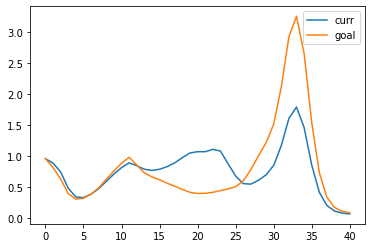

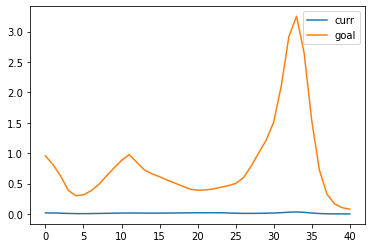

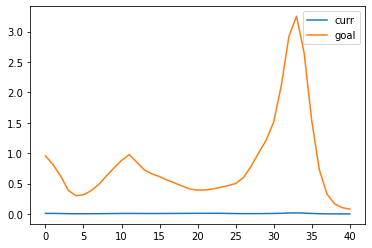

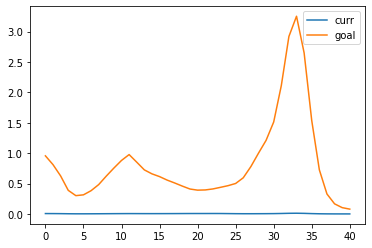

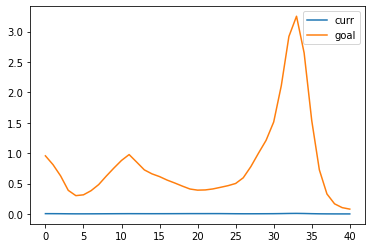

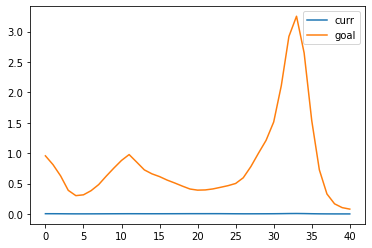

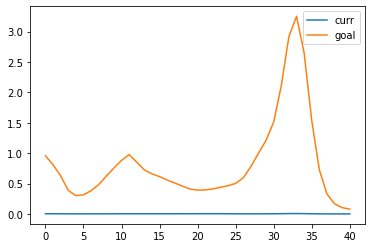

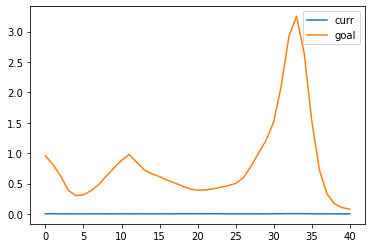

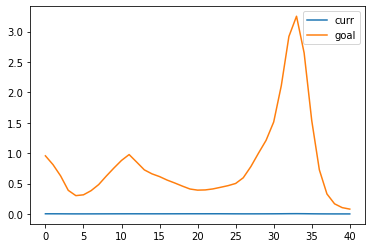

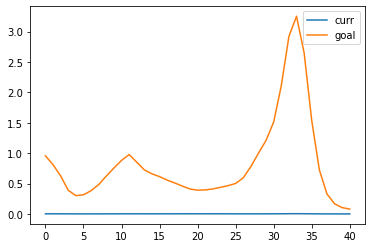

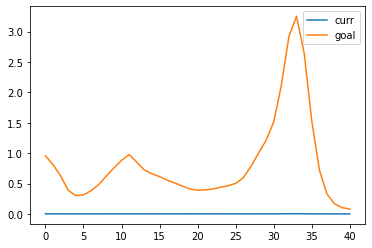

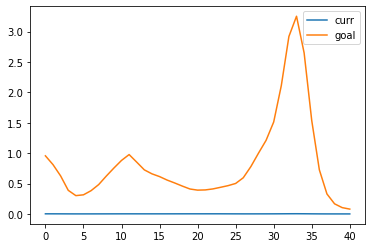

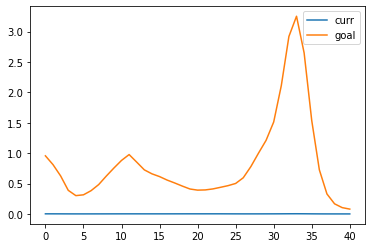

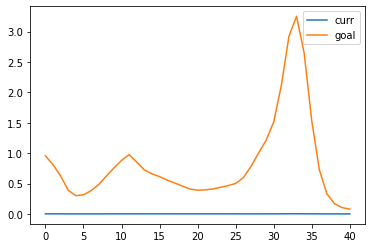

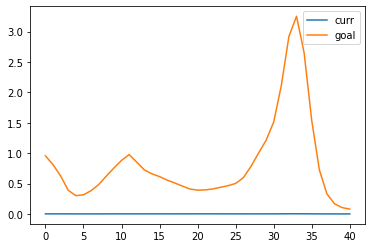

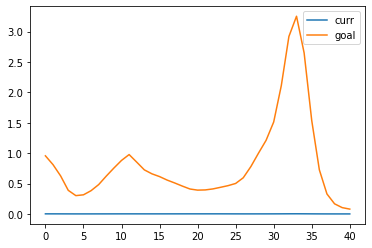

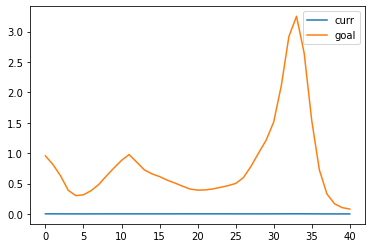

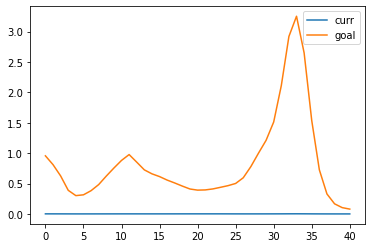

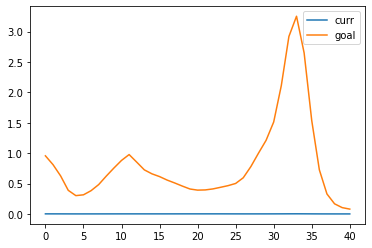

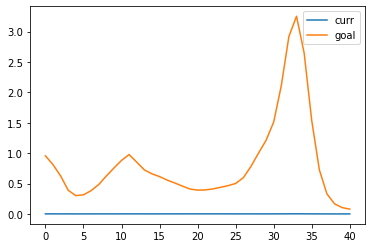

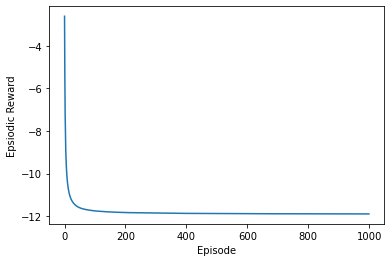

Text(0, 0.5, 'Critic Loss')

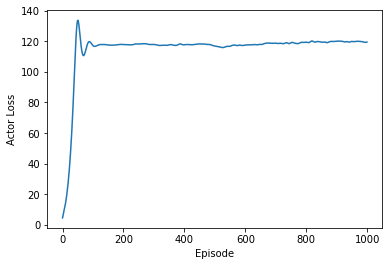

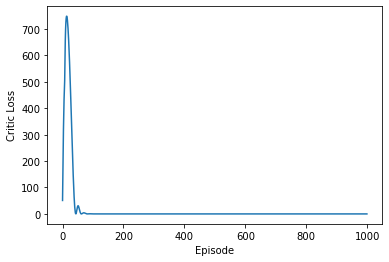

In [12]:
ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []
actor_loss_list = []
critic_loss_list = []

# Takes about 4 min to train
for ep in range(total_episodes):

    prev_state = env.reset()
    episodic_reward = 0

    while True:
        tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)

        action = policy(tf_prev_state, ou_noise)
        # Recieve state and reward from environment.
        state, reward, done, info = env.step(action)


        obs_tuple = (prev_state, action, reward, state)
        buffer.record(obs_tuple)
        episodic_reward += reward


        x, y = buffer.learn()
        actor_loss_list.append(x)
        critic_loss_list.append(y)
        update_target(target_actor.variables, actor_model.variables, tau)
        update_target(target_critic.variables, critic_model.variables, tau)

        # End this episode when `done` is True
        if done:
            break

        prev_state = state

    ep_reward_list.append(episodic_reward)
    # Mean of last 40 episodes
    avg_reward = np.mean(ep_reward_list[-40:])
    #print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward))
    avg_reward_list.append(avg_reward)

# Plotting graph
# Episodes versus Avg. Rewards
plt.figure()
plt.plot(ep_reward_list)
plt.xlabel("Episode")
plt.ylabel("Epsiodic Reward")
plt.show()
plt.figure()
plt.plot(actor_loss_list)
plt.xlabel("Episode")
plt.ylabel("Actor Loss")
plt.figure()
plt.plot(critic_loss_list)
plt.xlabel("Episode")
plt.ylabel("Critic Loss")

In [13]:
            #tf.print(critic_value)
            #tf.print(reward_batch)
            #tf.print(y-critic_value)
            #tf.print(tf.math.square(y - critic_value))